In [1]:
import torch
import scanpy as sc
import numpy as np
import scvi
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import poisson_atac as patac
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from anndata import AnnData
import anndata
import os
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

Global seed set to 0


['default', 'despine']


In [2]:
print(scvi.__version__)
print(sc.__version__)
output_dir = "."

0.17.1
1.9.1


In [3]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [4]:
adata_gex = adata[:,adata.var["modality"]=="GEX"].copy()
adata_atac = adata[:,adata.var["modality"]=="ATAC"].copy()

In [5]:
adata_gex.layers["counts"] = adata_gex.X.copy() 
sc.pp.normalize_total(adata_gex, target_sum=1e4)
sc.pp.log1p(adata_gex)

In [6]:
sc.pp.highly_variable_genes(
    adata_gex,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)


In [7]:
adata_atac.layers["counts"] = adata_atac.X.copy() 

In [8]:
n_peaks_before = adata_atac.shape[1]

In [9]:
sc.pp.filter_genes(adata_atac, min_cells=int(adata_atac.shape[0]*0.02))

In [10]:
print(f"filtered {n_peaks_before - adata_atac.n_vars} peaks.")

filtered 102443 peaks.


Concatenate GEX and ATAC

In [11]:
adata_multiome = anndata.concat([adata_gex, adata_atac], axis=1, join="inner")

In [12]:
adata_multiome.obs["batch_id"] = 1
adata_multiome.obs["modality"] = "paired"

In [13]:
adata_multiome.layers["counts"] = hstack([adata_gex.layers["counts"], adata_atac.layers["counts"]])

In [14]:
patac.model.MULTIVI.setup_anndata(adata_multiome, layer="counts", batch_key="batch_id")

In [15]:
multi_vi = patac.model.MULTIVI(adata_multiome, n_genes=(adata_multiome.var['modality']=='GEX').sum(),
    n_regions=(adata_multiome.var['modality']=='ATAC').sum())


In [16]:
multi_vi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/500:   0%|                                                                                | 0/500 [00:00<?, ?it/s]

/home/icb/dominik.klein/git_repos/scatac_poisson/poisson_atac/module/_poissonmultivae.py:583: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660070785140/work/aten/src/ATen/native/TensorShape.cpp:2981.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


Epoch 186/500:  37%|███████████████▌                          | 186/500 [38:44<1:05:23, 12.50s/it, loss=1.94e+04, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 39395.180. Signaling Trainer to stop.


In [17]:
multi_vi

MultiVI Model with INPUTS: n_genes:2000, n_regions:125816
n_hidden: 357, n_latent: 18, n_layers_encoder: 2, n_layers_decoder: 2 , dropout_rate: 0.1, 
latent_distribution: normal, deep injection: False, gene_likelihood: zinb, peak_likelihood: 
poisson
Training status: Trained

<AxesSubplot:xlabel='epoch', ylabel='kl_global_train'>

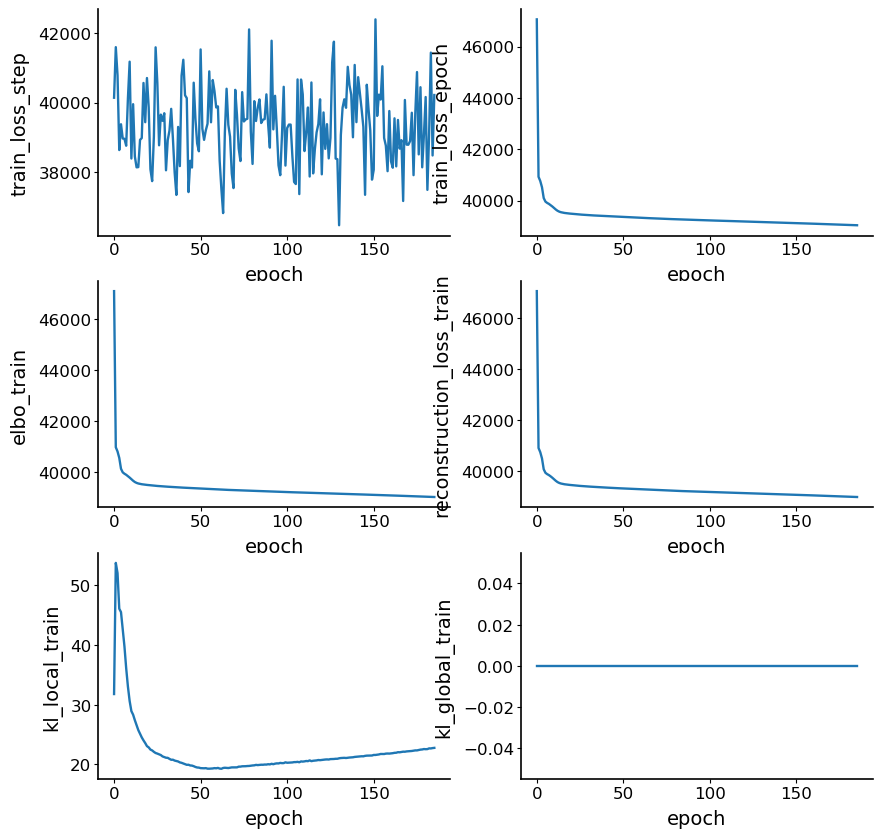

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

sns.lineplot(data=multi_vi.history['train_loss_step'], x="epoch", y="train_loss_step", ax=axs[0][0])
sns.lineplot(data=multi_vi.history['train_loss_epoch'], x="epoch", y="train_loss_epoch", ax=axs[0][1])
sns.lineplot(data=multi_vi.history['elbo_train'], x="epoch", y="elbo_train", ax=axs[1][0])
sns.lineplot(data=multi_vi.history['reconstruction_loss_train'], x="epoch", y='reconstruction_loss_train', ax=axs[1][1])
sns.lineplot(data=multi_vi.history['kl_local_train'], x="epoch", y='kl_local_train', ax=axs[2][0])
sns.lineplot(data=multi_vi.history['kl_global_train'], x="epoch", y='kl_global_train', ax=axs[2][1])

In [19]:
adata_multiome.obsm["X_multi_vi"]=multi_vi.get_latent_representation()

In [20]:
adata_multiome.obs["celltype"] = adata.obs["celltype"]

In [21]:
adata_multiome.obs["sample"] = adata.obs["sample"]

[<AxesSubplot:title={'center':'sample'}, xlabel='X_multi_vi1', ylabel='X_multi_vi2'>,
 <AxesSubplot:title={'center':'celltype'}, xlabel='X_multi_vi1', ylabel='X_multi_vi2'>]

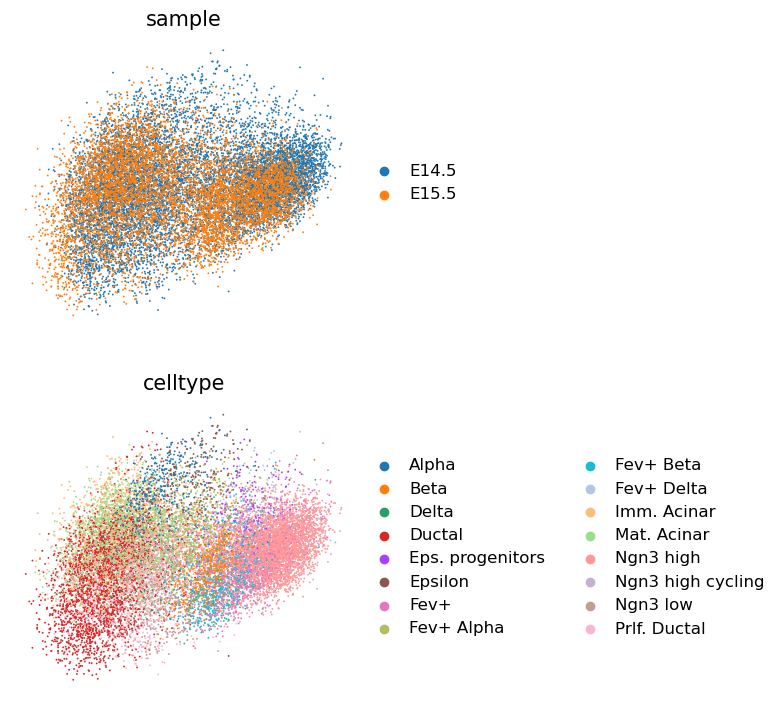

In [22]:
sc.pl.embedding(
    adata_multiome,
    basis="X_multi_vi",
    color=["sample", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)

In [23]:
sc.pp.neighbors(adata_multiome, use_rep="X_multi_vi", key_added="multi_vi")

In [24]:
sc.tl.umap(adata_multiome, neighbors_key="multi_vi")

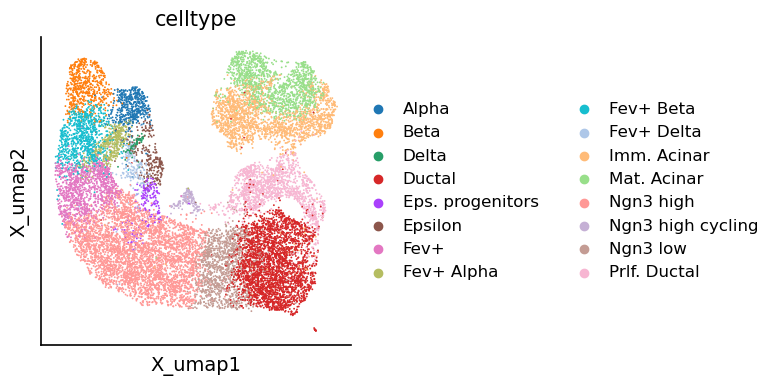

In [25]:
fig = sc.pl.embedding(adata_multiome, basis="X_umap", color=["celltype"], show=False)

In [26]:
fig.figure.savefig(os.path.join(output_dir, 'X_multivi_umap_celltype.png'))

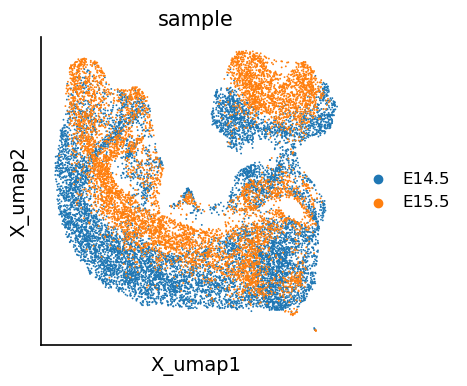

In [27]:
fig = sc.pl.embedding(adata_multiome, basis="X_umap", color=["sample"], show=False)

In [28]:
fig.figure.savefig(os.path.join(output_dir, 'X_multivi_umap_sample.png'))

In [29]:
adata.obsm["X_umap_multiVI"] = adata.obsm["X_umap"].copy()

In [31]:
multi_vi.save("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/models/MultiVI", overwrite=True, save_anndata=True)

# Batch correction

In [32]:
patac.model.MULTIVI.setup_anndata(adata_multiome, layer="counts", batch_key="sample")

In [33]:
multi_vi = patac.model.MULTIVI(adata_multiome, n_genes=(adata_multiome.var['modality']=='GEX').sum(),
    n_regions=(adata_multiome.var['modality']=='ATAC').sum())

In [34]:
multi_vi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/dominik.klein/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 166/500:  33%|█████████████▉                            | 166/500 [34:40<1:09:46, 12.54s/it, loss=1.96e+04, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 39400.164. Signaling Trainer to stop.


<AxesSubplot:xlabel='epoch', ylabel='kl_global_train'>

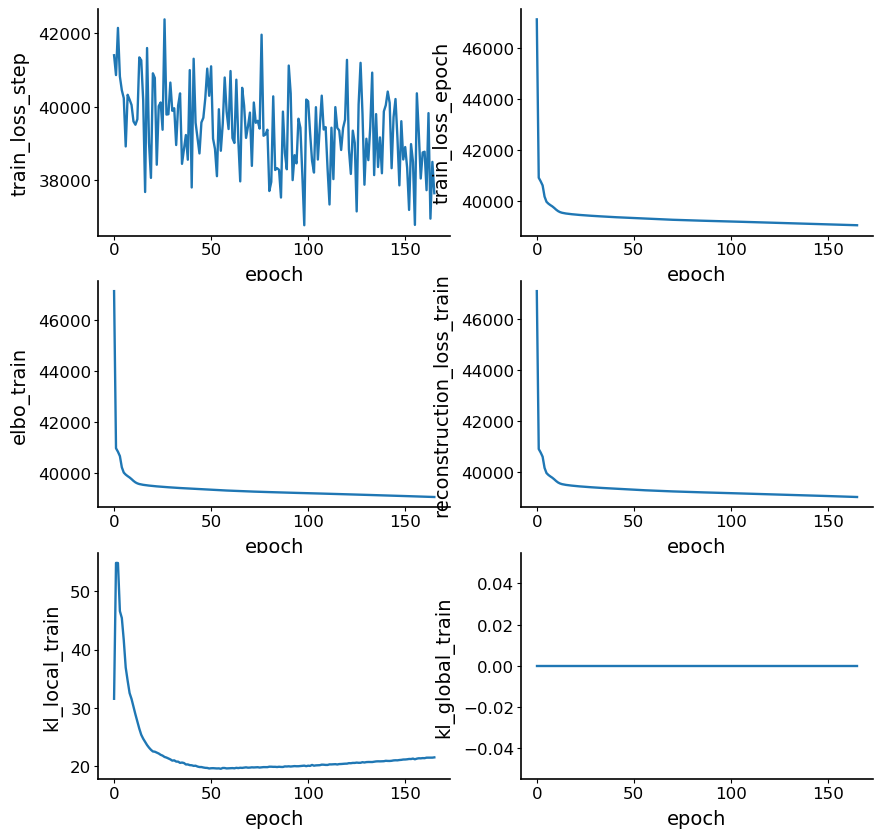

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

sns.lineplot(data=multi_vi.history['train_loss_step'], x="epoch", y="train_loss_step", ax=axs[0][0])
sns.lineplot(data=multi_vi.history['train_loss_epoch'], x="epoch", y="train_loss_epoch", ax=axs[0][1])
sns.lineplot(data=multi_vi.history['elbo_train'], x="epoch", y="elbo_train", ax=axs[1][0])
sns.lineplot(data=multi_vi.history['reconstruction_loss_train'], x="epoch", y='reconstruction_loss_train', ax=axs[1][1])
sns.lineplot(data=multi_vi.history['kl_local_train'], x="epoch", y='kl_local_train', ax=axs[2][0])
sns.lineplot(data=multi_vi.history['kl_global_train'], x="epoch", y='kl_global_train', ax=axs[2][1])

In [36]:
adata_multiome.obsm["X_multi_vi_batch_corrected"]=multi_vi.get_latent_representation()

[<AxesSubplot:title={'center':'sample'}, xlabel='X_multi_vi_batch_corrected1', ylabel='X_multi_vi_batch_corrected2'>,
 <AxesSubplot:title={'center':'celltype'}, xlabel='X_multi_vi_batch_corrected1', ylabel='X_multi_vi_batch_corrected2'>]

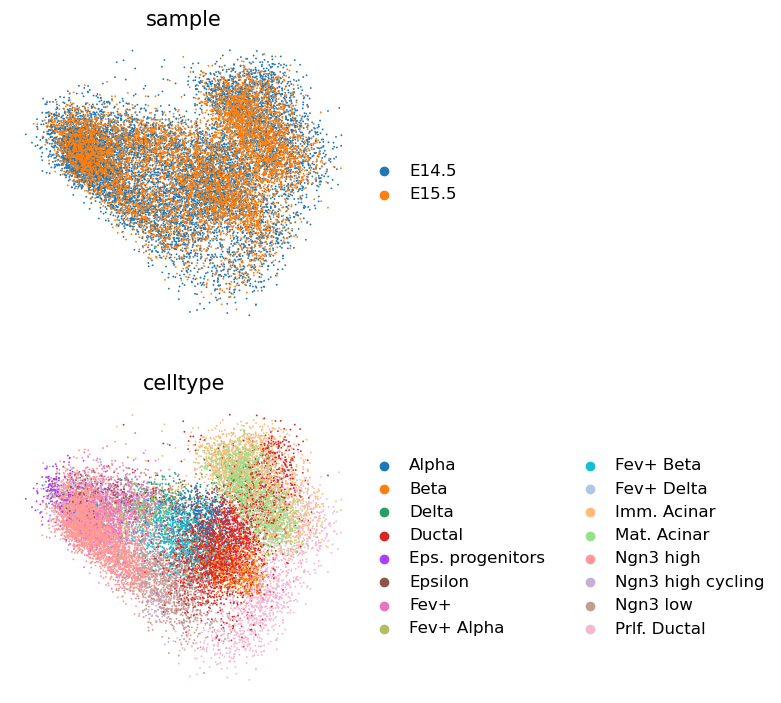

In [37]:
sc.pl.embedding(
    adata_multiome,
    basis="X_multi_vi_batch_corrected",
    color=["sample", "celltype"],
    frameon=False,
    ncols=1,
    show=False
)

In [38]:
sc.pp.neighbors(adata_multiome, use_rep="X_multi_vi_batch_corrected", key_added="multi_vi_batch_corrected")

In [39]:
sc.tl.umap(adata_multiome, neighbors_key="multi_vi_batch_corrected")

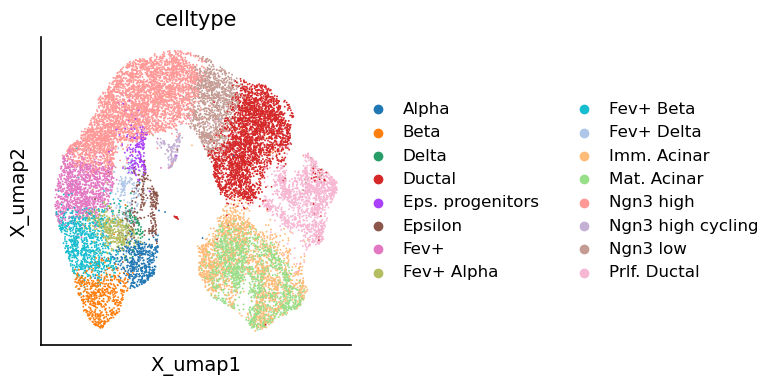

In [40]:
fig = sc.pl.embedding(adata_multiome, basis="X_umap", color=["celltype"], show=False)

In [41]:
fig.figure.savefig(os.path.join(output_dir, 'X_multivi_umap_batch_corrected_celltype.png'))

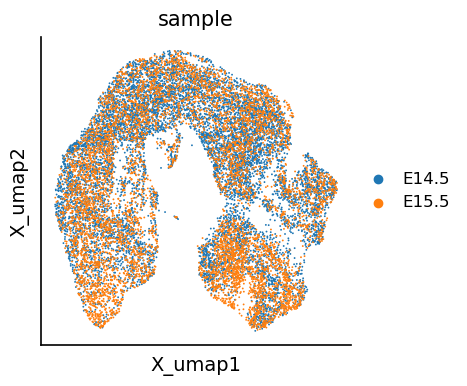

In [42]:
fig = sc.pl.embedding(adata_multiome, basis="X_umap", color=["sample"], show=False)

In [43]:
fig.figure.savefig(os.path.join(output_dir, 'X_multivi_umap_batch_corrected_sample.png'))

In [44]:
adata_multiome.obsm["X_umap_multiVI"] = adata_multiome.obsm["X_umap"].copy()

In [45]:
multi_vi.save("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/models/MultiVI_batch_corrected", overwrite=True, save_anndata=True)

In [46]:
adata_multiome.write("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/pancreas_shared_embeddings.h5ad")